In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt 

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.utils_v2 import get_datasets_base_path

In [2]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

taf_source = Traditional_Accessor_Factory(
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    num_examples_per_domain_per_label=100,
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_1300Examples_stratified_ds.2022A.pkl"),
    seed=1337
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()

ORACLE is sampled at 5Msps, the rest are at 20Msps

In [3]:
x,y,u = next(iter(train_original_source))
x.shape

torch.Size([2, 256])

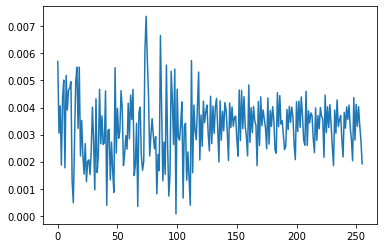

In [4]:
# Time domain of magnitude
x_t = x.T
mag = np.linalg.norm(x_t, axis = 1)



plt.plot(
    range(len(mag)),
    mag, 
)

In [5]:
# Stolen from https://stackoverflow.com/questions/2598734/numpy-creating-a-complex-array-from-2-real-ones
c = np.apply_along_axis(lambda args: [complex(*args)], 1, x.T).flatten()

In [6]:
f = 5e6

signal_spectrum = np.fft.fftshift(np.fft.fft(c))
freqs = np.fft.fftshift(np.fft.fftfreq(len(c), d=1.0/f))

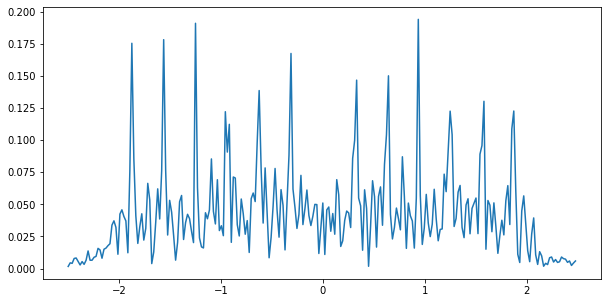

In [7]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz
# plt.xlim(70, 170)

Lets upsample now...  
We do this by inserting 'z' zeros, and then lowpass filtering the result to the original bandwidth

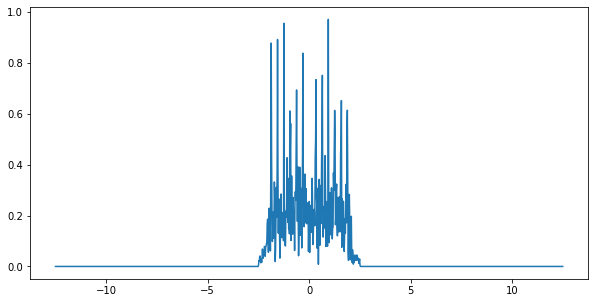

In [8]:
from scipy import signal

new = signal.resample(c, len(c)*5)

f = 25e6

signal_spectrum = np.fft.fftshift(np.fft.fft(new))
freqs = np.fft.fftshift(np.fft.fftfreq(len(new), d=1.0/f))

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

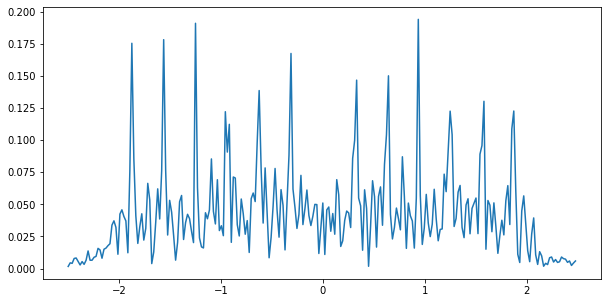

In [9]:
new = signal.resample(c, len(c)*5)
new = signal.resample(new, len(new)//5)

f = 5e6

signal_spectrum = np.fft.fftshift(np.fft.fft(new))
freqs = np.fft.fftshift(np.fft.fftfreq(len(new), d=1.0/f))

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

### How does this compare to CORES?

In [10]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

taf_source = Traditional_Accessor_Factory(
    labels=ALL_NODES,
    domains=[1],
    num_examples_per_domain_per_label=100,
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    seed=1337
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()

In [11]:
x,y,u = next(iter(train_original_source))
x.shape

torch.Size([2, 256])

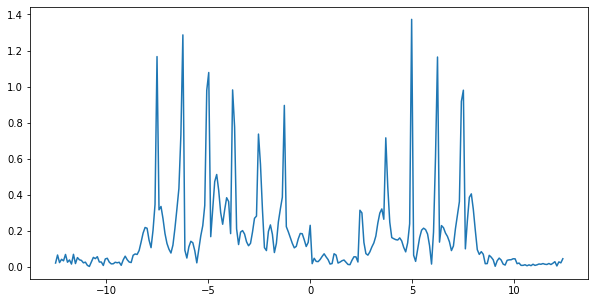

In [12]:
c = np.apply_along_axis(lambda args: [complex(*args)], 1, x.T).flatten()
f = 25e6

signal_spectrum = np.fft.fftshift(np.fft.fft(c))
freqs = np.fft.fftshift(np.fft.fftfreq(len(c), d=1.0/f))

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

Clearly there are things going on outside of +/i 2.5MHz, so the ORACLE data still doesn't really look like CORES data. What if we were to lowpass filter CORES?

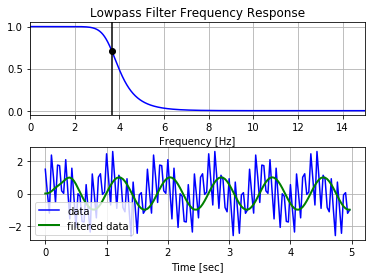

In [13]:
# Taken from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

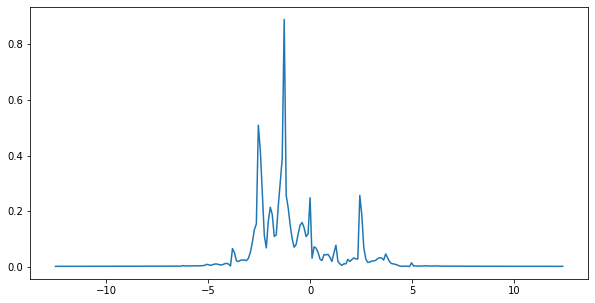

In [18]:
# Taken from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 25e6       # sample rate, Hz
cutoff = 2.5e6  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)


y = butter_lowpass_filter(c, cutoff, fs, order)
f = 25e6

signal_spectrum = np.fft.fftshift(np.fft.fft(y))
freqs = np.fft.fftshift(np.fft.fftfreq(len(y), d=1.0/f))

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz